# Sign Language Gesture Recognition using Computer Vision in Real-time
Senior Project 2023 Semester II
Prepared by 
Puja Karmakar | 20194981 , Afifa Mohamed | 20183087 , Zainab Redha  | 20195982 

# Dependencies For the SignML Project
Sign Language (SL) is a visual language characterized by the formation of manual signs. SL utilizes a unique form of syntax to communicate thoughts, feelings, and ideas. We are using following libraries and dependencies in order to create an environment
to run our Machine Learning (ML) model that predicts Sign Language Gestures. In our senior project we are utilising the 45 Dynamic American Sign Language (ASL) Gestures on Word-Level to train in various ML algorithms and predict results.

In [ ]:
#!pip install opencv-python mediapipe sklearn matplotlib
#!pip install pydot
#!pip install pydotplus
#!sudo apt-get install graphviz

In [1]:
# import the required libraries
import os                               # operating system
import tensorflow as tf                 # tensorFlow
import cv2                              # openCV-Computer Vision
import numpy as np                      # numpyArray
from matplotlib import pyplot as plt    # plotting library
import time                             # time stamps
import mediapipe as mp                  # mediapipe

# MediaPipe Data Preparation Tasks
MediaPipe provides a suite of libraries and tools for you to quickly apply artificial intelligence (AI) and machine learning (ML) techniques.

In [2]:
mp_holistic = mp.solutions.holistic      # holistic pipeline model
mp_drawing = mp.solutions.drawing_utils  # drawing utilities

In [3]:
# Function will extract frames from a video using OpenCV to intialise mediapipe features
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # image is no longer writeable
    results = model.process(image)                 # make prediction
    image.flags.writeable = True                   # image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    STATIC_IMAGE_MODE = True                       # detection runs every input image
    ENABLE_SEGMENTATION = True                     # generates the segmentation mask
    return image, results

In [4]:
# Function will draw landamrks for face, pose, left and right hands on frames to process
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS)   # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)  # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [5]:
# customising the drawn landmarks
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(255,255,255), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(255,255,0), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [6]:
# extracting keypoints 1404 face landmarks, 132 pose landmarks, 63 righthand and 63 lefthand landmarks
# total of 1662 featues are extracted from each frames
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

# Setup For Data Collection folders

In [7]:
# Path for exported data with numpy arrays
DATA_PATH = os.path.join('D:\DATA_45WORDS') 

# Actions that we will detect using ML Models
# 45 actions for gesture recognition
actions = np.array(['Iloveyou','Remember','Want','Father','Mother','Hungry',
                    'Cat','House','Hear','Book','Water','Help','Important',
                    'School','Enjoy', 'Why', 'Write', 'Teacher', 'See', 'Quiet','You',
                    'Boy','Girl','Beautiful', 'Thankyou','No', 'Yes', 'Please', 'Babysitter',
                   'Birthday','Come','Doctor','Eat','Give','Go','Goodbye','Hello','How','Man','Name',
                   'Stop','Shirt','What','World','Woman'])

no_sequences = 30     # thirty videos worth of data
sequence_length = 30  # videos to be 30 frames in length

In [8]:
# Reading the data from path and organising them into actions
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.dirs(os.path.read(DATA_PATH, action, str(sequence)))
        except:
            pass

# Creating the Dataset and Extracting Keypoints To Train

In [ ]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.7, min_tracking_confidence=0.7) as holistic:
    
    # Loop through actions
    for action in actions:
        # Loop through sequences of videos
        for sequence in range(no_sequences):
             # Loop through video sequence length
            for frame_num in range(sequence_length):
                # Read feed
                ret, frame = cap.read() 
                
                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # applying wait logic to collect keypoints smoothly
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION THE DATA', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                # Show in the screen using OpenCV
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(1000) # waiting using waitKey method
                else:
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                cv2.imshow('OpenCV Feed', image)
                
        
                 # export keypoints on numpy array
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
# destroy all the OpenCv opened window
cap.release()
cv2.destroyAllWindows()

# Pre-process Data and Create Labels

In [9]:
# import dependencies
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [10]:
# labelling the actions
label_map = {label:num for num, label in enumerate(actions)}

In [11]:
label_map

{'Iloveyou': 0,
 'Remember': 1,
 'Want': 2,
 'Father': 3,
 'Mother': 4,
 'Hungry': 5,
 'Cat': 6,
 'House': 7,
 'Hear': 8,
 'Book': 9,
 'Water': 10,
 'Help': 11,
 'Important': 12,
 'School': 13,
 'Enjoy': 14,
 'Why': 15,
 'Write': 16,
 'Teacher': 17,
 'See': 18,
 'Quiet': 19,
 'You': 20,
 'Boy': 21,
 'Girl': 22,
 'Beautiful': 23,
 'Thankyou': 24,
 'No': 25,
 'Yes': 26,
 'Please': 27,
 'Babysitter': 28,
 'Birthday': 29,
 'Come': 30,
 'Doctor': 31,
 'Eat': 32,
 'Give': 33,
 'Go': 34,
 'Goodbye': 35,
 'Hello': 36,
 'How': 37,
 'Man': 38,
 'Name': 39,
 'Stop': 40,
 'Shirt': 41,
 'What': 42,
 'World': 43,
 'Woman': 44}

# Loading Sequences in Datapath
This code loads each frame and constructs a sliding window of video sequence_length over the frames. The resulting windows are stored in the sequences list, and their corresponding labels are stored in the labels list.

In [12]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [13]:
# converting the sequences and labels to numpy arrays for training
X = np.array(sequences)
Y = np.array(labels).astype(int)
print("Images loaded: ", len(X))
print("Labels loaded: ", len(actions))

Images loaded:  1350
Labels loaded:  45


In [16]:
print("Shape of the frame sequences: ", X.shape)
print("Total frames: ", Y.shape)

Shape of the frame sequences:  (1350, 30, 1662)
Total frames:  (1350,)


In [20]:
print("Arrays in the first sequences: ", X[0])
print("frames in integers: ", Y)

Arrays in the first sequences:  [[ 0.58578485  0.18370976 -0.82515413 ...  0.          0.
   0.        ]
 [ 0.58749855  0.18562393 -1.1476419  ...  0.          0.
   0.        ]
 [ 0.58766788  0.1863725  -1.19974518 ...  0.          0.
   0.        ]
 ...
 [ 0.60309261  0.19436401 -1.11542392 ...  0.          0.
   0.        ]
 [ 0.60255557  0.19434646 -1.10862005 ...  0.          0.
   0.        ]
 [ 0.6017074   0.19418928 -1.13617802 ...  0.          0.
   0.        ]]
frames in integers:  [ 0  0  0 ... 44 44 44]


# Splitting Data for Training Models
Splitting that datasets into training set and testing set

In [14]:
# Split the data into Train ( 70% ) and Test (20%)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

n = len(sorted(os.listdir(DATA_PATH)))
train_n = len(X_train)
test_n = len(X_test)

print("Total number of SL words: ", n)
print("Number of training images: " , train_n)
print("Number of testing images: ", test_n)

Total number of SL words:  45
Number of training images:  1080
Number of testing images:  270


In [18]:
X_train.shape, X_test.shape

((1080, 30, 1662), (270, 30, 1662))

In [59]:
Y_train.shape,Y_test.shape

((1080,), (270,))

In [60]:
print(X_test.shape[0]) # images 
print(X_test.shape[1]) # frame length
print(X_test.shape[2]) # Keypoint features

270
30
1662


# Scaling and Normalizing Data
This code is used to scale and normalize the data in the training and testing sets. The StandardScaler function from the scikit-learn library is used to scale the data so that each feature has zero mean and unit variance. It is important for accurate model training and evaluation.

In [21]:
from sklearn.preprocessing import StandardScaler
scalers = {}
for i in range(X_train.shape[2]): #training set
    scalers[i] = StandardScaler()
    X_train[:, :, i] = scalers[i].fit_transform(X_train[:, :, i]) 

for i in range(X_test.shape[2]): #testing set
    X_test[:, :, i] = scalers[i].transform(X_test[:, : , i])

In [22]:
# Applying the function to training set labels and testing set labels
from keras.utils import to_categorical
train_X = X_train #used on CNN Model
test_X = X_test
# converted to a one-hot encoded format
train_Y = to_categorical(Y_train) # converted to a one-hot encoded format
test_Y = to_categorical(Y_test)

#Flattens images to 2-D vector  
#Coverts the 3-D NumPy array of dimension to a 2-D array
dataset_size_train = len(X_train)
X_train = X_train.reshape(dataset_size_train,-1) 

dataset_size_test = len(X_test)
X_test = X_test.reshape(dataset_size_test,-1)

X_train.shape,X_test.shape

((1080, 49860), (270, 49860))

In [21]:
print(dataset_size_train)
print(dataset_size_test)
print(train_Y.shape)
print(test_Y.shape)

1080
270
(1080, 45)
(270, 45)


In [63]:
X_train

array([[ 0.04102771, -0.47069383,  0.62604686, ...,  0.13462322,
         0.14891553,  0.22704808],
       [-1.28609637, -0.42996392,  1.55925992, ...,  0.59464356,
        -0.82603225,  0.01354868],
       [-0.36079136,  0.71857692,  0.89882112, ...,  0.06118911,
         1.05497591,  0.35944285],
       ...,
       [-0.62171292, -0.51205606, -0.05394057, ...,  1.07332165,
         0.49816194, -0.45296816],
       [ 0.89722796, -1.51382805, -0.39503419, ...,  0.88367153,
         0.99506898, -1.72324479],
       [-0.87669104,  0.23372784,  1.02274564, ...,  0.32444855,
         0.57859578,  0.30099365]])

In [52]:
X_train[0,0,0] # looking at the first array point from training set

0.04102770568284403

In [66]:
X_test

array([[ 1.10006462,  0.95448722,  0.7975287 , ...,  1.10475273,
         0.91643922, -1.77849819],
       [-0.84349029, -0.25785727,  0.55252237, ..., -1.36977997,
        -1.30946524,  0.80799867],
       [-1.23612571, -0.24787648,  0.64228398, ...,  0.57728857,
         1.67000896, -1.16797179],
       ...,
       [ 0.5632658 ,  0.02403994, -0.3342634 , ...,  1.02276857,
         0.36107974, -0.70709858],
       [-0.37907666, -0.34791451, -0.26087565, ...,  0.54569501,
         0.68613781, -0.84300039],
       [ 1.20009908,  1.31234837, -0.23088315, ...,  0.63138299,
         0.66422385, -0.92532972]])

In [54]:
X_test[0,0,0] # looking at the first array point from testing set

1.1000646156335525

# Validating using SVM
SVM is a machine learning algorithm for classification and regression. It finds the best hyperplane to separate data into classes with the largest margin. It's robust against noise and can handle non-linear data using the kernel trick. SVM is used in image and text classification, but can be sensitive to hyperparameters and slow for large datasets.

In [70]:
import time
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

SVM_classifier = SVC()
start = time.time()
SVM_classifier.fit(X_train, Y_train)
train_time_SVM = time.time() - start

print("Train time: ",train_time_SVM)

Train time:  36.881778955459595


In [76]:
# Predicting the Training set results
t1 = time.time()
Y_pred = SVM_classifier.predict(X_train)
t2 = time.time()
print("Accuracy Score of SVM: ", accuracy_score(Y_train,Y_pred)*100) # convert into percentage
print('Time taken was {} seconds'.format( t2 - t1))

Accuracy Score of SVM:  87.5925925925926
Time taken was 69.30084013938904 seconds


In [77]:
time_one_pred = (t2-t1)/len(X_train)
print('Time taken per prediction {} seconds'.format(time_one_pred))

Time taken per prediction 0.06416744457350837 seconds


In [75]:
# Predicting the Test set results
t1 = time.time()
Y_pred = SVM_classifier.predict(X_test)
t2 = time.time()
print("Testing Accuracy Score of SVM: ", accuracy_score(Y_test,Y_pred)*100) # convert into percentage
print('Time taken was {} seconds'.format( t2 - t1))

Testing Accuracy Score of SVM:  74.44444444444444
Time taken was 16.735515117645264 seconds


In [ ]:
# file format used for storing data
import h5py
# save the model to a file
with h5py.File('SVM_classifier.h5', 'w') as f:
    f.create_dataset('SVM_classifier', data=SVM_classifier)

# load the saved model from a file
# with h5py.File('SVM_classifier', 'r') as f:
#    model = f['SVM_classifier'][()]

# Validating using CNN
CNNs are deep learning algorithms used for image and video processing tasks. They use filters to extract features from input images, downsampled by pooling layers, and use fully connected layers to perform classification. They achieve state-of-the-art performance in computer vision tasks.

In [23]:
#libraries & Dependencies
import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Flatten,Dropout,BatchNormalization,Conv2D,MaxPool2D
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras.layers.convolutional import Conv2D, MaxPooling2D
import time
from sklearn.metrics import accuracy_score

In [24]:
n_timesteps, n_features, n_outputs = train_X.shape[1], train_X.shape[2], test_Y.shape[1]
print("Video time frames:", n_timesteps)
print("Keypoint Features:", n_features)
print("Action words:", n_outputs)

train_n = len(train_X)
test_n = len(test_Y)
print("Number of training images: " , train_n)
print("Number of testing images: ", test_n)

Video time frames: 30
Keypoint Features: 1662
Action words: 45
Number of training images:  1080
Number of testing images:  270


In [28]:
#3 Layers of CNN model
def create_CNN_model():
# model Summary
    model = Sequential()
    model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(n_timesteps,n_features, 1))) 
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu')) 
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.summary()
    return model

In [29]:
# Construct the required CNN model.
CNN_model = create_CNN_model()

# Display the success message. 
print("CNN Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 1658, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 829, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 827, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 413, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 411, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 205, 64)       0

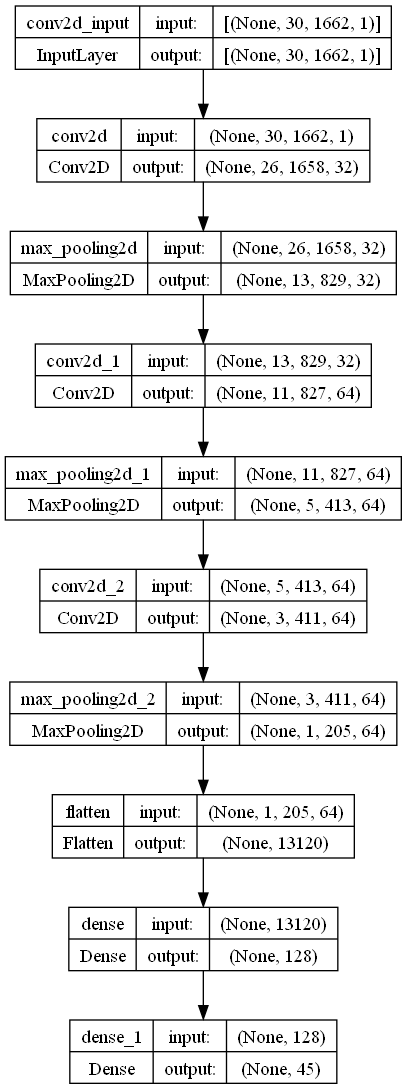

In [26]:
# Plot the structure of the contructed model
from tensorflow.keras.utils import plot_model
plot_model(CNN_model, to_file = 'CNN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [30]:
# Compile the model 
# Specify loss function, optimizer and metrics values to the CNN model
CNN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
# fit model
verbose, epochs, batch_size = 1, 15, 32

start = time.time()
history = CNN_model.fit(train_X, train_Y, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0.1, shuffle = True)
train_time_CNN = time.time() - start

Epoch 1/15
31/31 [==============================] - 43s 1s/step - loss: 3.6643 - accuracy: 0.0761 - val_loss: 3.0002 - val_accuracy: 0.2222
Epoch 2/15
31/31 [==============================] - 32s 1s/step - loss: 2.9015 - accuracy: 0.2438 - val_loss: 2.3814 - val_accuracy: 0.3796
Epoch 3/15
31/31 [==============================] - 32s 1s/step - loss: 2.2733 - accuracy: 0.3940 - val_loss: 2.0327 - val_accuracy: 0.4074
Epoch 4/15
31/31 [==============================] - 33s 1s/step - loss: 1.6229 - accuracy: 0.5278 - val_loss: 1.4886 - val_accuracy: 0.6019
Epoch 5/15
31/31 [==============================] - 33s 1s/step - loss: 1.2283 - accuracy: 0.6728 - val_loss: 1.3064 - val_accuracy: 0.7315
Epoch 6/15
31/31 [==============================] - 33s 1s/step - loss: 0.9472 - accuracy: 0.7418 - val_loss: 1.1641 - val_accuracy: 0.7037
Epoch 7/15
31/31 [==============================] - 32s 1s/step - loss: 0.7217 - accuracy: 0.7860 - val_loss: 1.0512 - val_accuracy: 0.7500
Epoch 8/15
31/31 [==

In [25]:
from tensorflow.keras.models import load_model

# Load the saved model file
model_path = 'CNN_model.h5'
loaded_model = load_model(model_path)

# Verify the loaded model
loaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 1658, 32)      832       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 829, 32)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 827, 64)       18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 5, 413, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 411, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 1, 205, 64)      

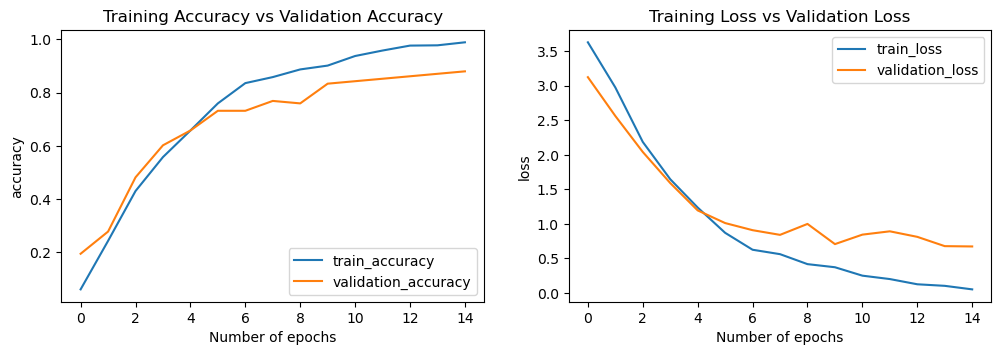

In [107]:
# Learning cure for CNN Model
plt.figure(figsize=(12, 12))
plt.subplot(3, 2, 1)
plt.title('Training Accuracy vs Validation Accuracy')
plt.plot(history.history['accuracy'], label = 'train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation_accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(3, 2, 2)
plt.title('Training Loss vs Validation Loss')
plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'validation_loss')
plt.xlabel('Number of epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

9/9 [==============================] - 3s 281ms/step


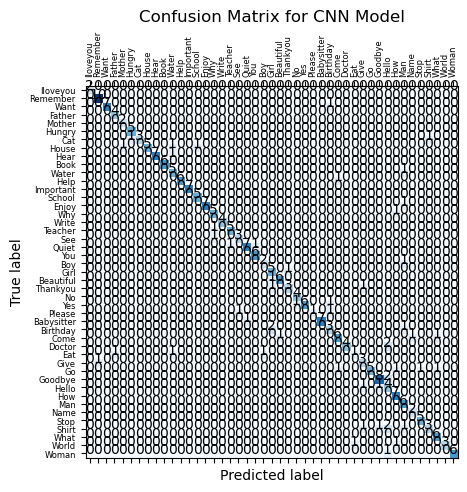

<Figure size 3000x3000 with 0 Axes>

In [108]:
#Confusion matrix for a classification task
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

y_pred = CNN_model.predict(test_X)
ytrue = np.argmax(test_Y, axis=1).tolist()
y_pred = np.argmax(y_pred, axis=1).tolist()

cm = confusion_matrix(ytrue, y_pred)
plt.matshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix for CNN Model')

for i in range(len(actions)):
    for j in range(len(actions)):
        plt.text(j, i, str(cm[i, j]), horizontalalignment='center')
plt.xticks(range(len(actions)), actions, fontsize=6, rotation=90)
plt.yticks(range(len(actions)), actions, fontsize=6)
plt.xlabel('Predicted label')
plt.ylabel('True label') 
plt.figure(figsize=(30, 30))
plt.show()

In [109]:
start = time.time()
test_loss, test_acc = CNN_model.evaluate(test_X, test_Y)
test_time_CNN = time.time() - start
print('Test accuracy: {:2.2f}%'.format(test_acc*100))

9/9 [==============================] - 3s 282ms/step - loss: 0.8858 - accuracy: 0.8037
Test accuracy: 80.37%


In [114]:
time_one_pred = (t2-t1)/len(test_X)
print('Time taken per prediction {} seconds'.format(time_one_pred))

Time taken per prediction 0.040537169244554305 seconds


In [111]:
# Predicting the Testing set results
t1 = time.time()
result1 = CNN_model.predict(test_X)
t2 = time.time()
print('Time taken was {} seconds'.format( t2 - t1))

9/9 [==============================] - 3s 285ms/step
Time taken was 2.738767147064209 seconds


In [112]:
test_loss, test_acc = CNN_model.evaluate(train_X, train_Y)
print('Train accuracy: {:2.2f}%'.format(test_acc*100))

34/34 [==============================] - 10s 306ms/step - loss: 0.1021 - accuracy: 0.9815
Train accuracy: 98.15%


In [113]:
# Predicting the Training set results
t1 = time.time()
result = CNN_model.predict(train_X)
t2 = time.time()
print('Time taken was {} seconds'.format( t2 - t1))

34/34 [==============================] - 11s 313ms/step
Time taken was 10.945035696029663 seconds


In [115]:
  print('\nTrain time for CNN: ', train_time_CNN)
  print('Test time for CNN: ', test_time_CNN)
  print('Test accuracy:', test_acc)
  print('Test loss:', test_loss)


Train time for CNN:  584.4407880306244
Test time for CNN:  2.719228506088257
Test accuracy: 0.9814814925193787
Test loss: 0.10209241509437561


In [116]:
# file format used for storing data
# Saving model weights
CNN_model.save('CNN_model.h5')

# Load the saved model
#from tensorflow.keras.models import load_model
#model = load_model('CNN_model.h5')

# Validating using LSTM 
LSTM networks are widely used in natural language processing, speech recognition, video analysis, and other applications where long-term dependencies and sequential data are present. They have been shown to be effective in modeling complex temporal patterns and outperform traditional RNNs in many tasks.

In [117]:
# libraries and dependencies
from keras.models import Sequential
from keras.layers import LSTM, ConvLSTM2D, Dense, Softmax, Dropout

In [119]:
n_timesteps, n_features, n_outputs = train_X.shape[1], train_X.shape[2], test_Y.shape[1]
print("Video time frames:", n_timesteps)
print("Keypoint Features:", n_features)
print("Action words:", n_outputs)

Video time frames: 30
Keypoint Features: 1662
Action words: 45


In [144]:
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(1080, 49860) (270, 49860) (1080,) (270,)


In [137]:
#LSTM layer for model
def create_LSTM_model():
    model = Sequential()
    model.add(LSTM(120, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.summary()
    return model

In [133]:
#LSTM Nicole layer for model
def create_LSTM_model():
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(LSTM(128, return_sequences=True, activation='relu'))
    model.add(LSTM(64, return_sequences=False, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.summary()
    return model

In [145]:
# Construct the required LSTM model.
LSTM_model = create_LSTM_model()

# Display the success message. 
print("LSTM Model Created Successfully!")

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 120)               855840    
                                                                 
 dropout_2 (Dropout)         (None, 120)               0         
                                                                 
 dense_14 (Dense)            (None, 100)               12100     
                                                                 
 dense_15 (Dense)            (None, 45)                4545      
                                                                 
Total params: 872,485
Trainable params: 872,485
Non-trainable params: 0
_________________________________________________________________
LSTM Model Created Successfully!


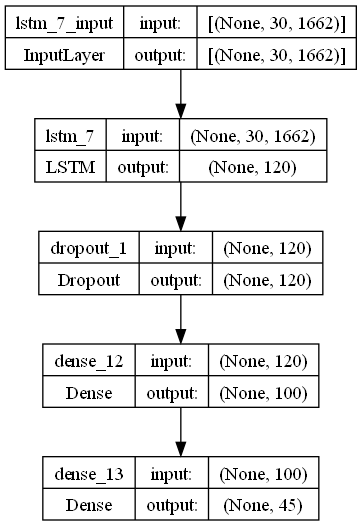

In [142]:
# Plot the structure of the contructed model
from tensorflow.keras.utils import plot_model
plot_model(LSTM_model, to_file = 'LSTM_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [147]:
# Compile the model 
# Specify loss function, optimizer and metrics values to the LSTM model
LSTM_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
# fit model
verbose, epochs, batch_size = 1, 20, 32

start = time.time()
history = LSTM_model.fit(train_X, train_Y, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0.1, shuffle = True)
train_time_LSTM = time.time() - start

Epoch 1/20
31/31 [==============================] - 7s 147ms/step - loss: 3.5775 - accuracy: 0.1060 - val_loss: 3.2281 - val_accuracy: 0.1852
Epoch 2/20
31/31 [==============================] - 4s 126ms/step - loss: 3.0869 - accuracy: 0.1914 - val_loss: 2.8472 - val_accuracy: 0.2685
Epoch 3/20
31/31 [==============================] - 4s 126ms/step - loss: 2.7459 - accuracy: 0.2767 - val_loss: 2.5215 - val_accuracy: 0.3333
Epoch 4/20
31/31 [==============================] - 4s 126ms/step - loss: 2.5085 - accuracy: 0.3148 - val_loss: 2.4289 - val_accuracy: 0.3426
Epoch 5/20
31/31 [==============================] - 4s 125ms/step - loss: 2.3208 - accuracy: 0.3601 - val_loss: 2.2483 - val_accuracy: 0.4259
Epoch 6/20
31/31 [==============================] - 4s 127ms/step - loss: 2.1677 - accuracy: 0.3909 - val_loss: 2.1021 - val_accuracy: 0.4167
Epoch 7/20
31/31 [==============================] - 4s 124ms/step - loss: 2.0094 - accuracy: 0.4393 - val_loss: 2.0075 - val_accuracy: 0.4630
Epoch 

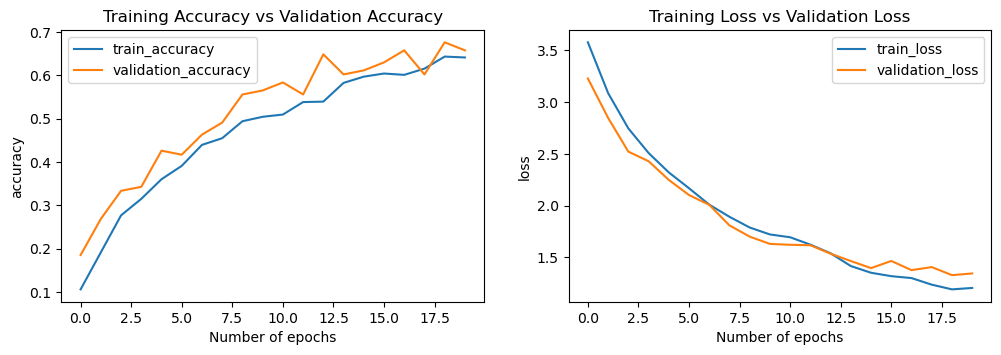

In [148]:
# Learning cure for LSTM Model
plt.figure(figsize=(12, 12))
plt.subplot(3, 2, 1)
plt.title('Training Accuracy vs Validation Accuracy')
plt.plot(history.history['accuracy'], label = 'train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation_accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(3, 2, 2)
plt.title('Training Loss vs Validation Loss')
plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'validation_loss')
plt.xlabel('Number of epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

9/9 [==============================] - 1s 37ms/step


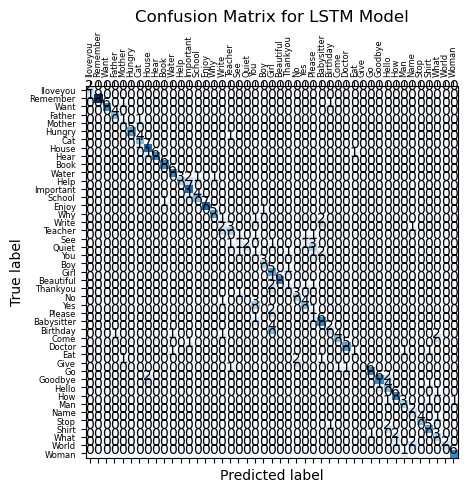

<Figure size 3000x3000 with 0 Axes>

In [149]:
#Confusion matrix for a classification task
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

y_pred = LSTM_model.predict(test_X)
ytrue = np.argmax(test_Y, axis=1).tolist()
y_pred = np.argmax(y_pred, axis=1).tolist()

cm = confusion_matrix(ytrue, y_pred)
plt.matshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix for LSTM Model')

for i in range(len(actions)):
    for j in range(len(actions)):
        plt.text(j, i, str(cm[i, j]), horizontalalignment='center')
plt.xticks(range(len(actions)), actions, fontsize=6, rotation=90)
plt.yticks(range(len(actions)), actions, fontsize=6)
plt.xlabel('Predicted label')
plt.ylabel('True label') 
plt.figure(figsize=(30, 30))
plt.show()

In [150]:
start = time.time()
test_loss, test_acc = LSTM_model.evaluate(test_X, test_Y)
test_time_LSTM = time.time() - start
print('Test accuracy: {:2.2f}%'.format(test_acc*100))

9/9 [==============================] - 0s 49ms/step - loss: 1.2800 - accuracy: 0.6593
Test accuracy: 65.93%


In [151]:
time_one_pred = (t2-t1)/len(test_X)
print('Time taken per prediction {} seconds'.format(time_one_pred))

Time taken per prediction 0.040537169244554305 seconds


In [152]:
# Predicting the Testing set results
t1 = time.time()
result2 = LSTM_model.predict(test_X)
t2 = time.time()
print('Time taken was {} seconds'.format( t2 - t1))

9/9 [==============================] - 0s 48ms/step
Time taken was 0.6548936367034912 seconds


In [153]:
test_loss, test_acc = LSTM_model.evaluate(train_X, train_Y)
print('Train accuracy: {:2.2f}%'.format(test_acc*100))

34/34 [==============================] - 2s 50ms/step - loss: 0.8522 - accuracy: 0.8056
Train accuracy: 80.56%


In [154]:
# Predicting the Training set results
t1 = time.time()
result = LSTM_model.predict(train_X)
t2 = time.time()
print('Time taken was {} seconds'.format( t2 - t1))

34/34 [==============================] - 2s 51ms/step
Time taken was 1.965392827987671 seconds


In [156]:
  print('\nTrain time for LSTM: ', train_time_LSTM)
  print('Test time for LSTM: ', test_time_LSTM)
  print('Test accuracy:', test_acc)
  print('Test loss:', test_loss)


Train time for LSTM:  82.29350280761719
Test time for LSTM:  0.6158161163330078
Test accuracy: 0.8055555820465088
Test loss: 0.8522067666053772


In [158]:
# file format used for storing data
# Saving model weights
LSTM_model.save('LSTM_model.h5')

# Load the saved model
#from tensorflow.keras.models import load_model
#model = load_model('LSTM_model.h5')

# Test Prediction in Real time
Sign Language Action Detection using Computer Vision

In [159]:
from scipy import stats

In [160]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num-2], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    return output_frame

In [46]:
 #1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.2

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.8, min_tracking_confidence=0.8) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = CNN_model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
        #3. Viz logic
            #if np.unique(predictions[-10:])[0]==np.argmax(res): 
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 1: 
                sentence = sentence[-1:]

        

        cv2.rectangle(image, (0,0), (640, 40), (255,0,0), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('Sign Language Detection', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

1/1 [==============================] - 0s 25ms/step
Man
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 38ms/step
Man
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 29ms/step
Man
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 33ms/step
Man
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
Man
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
Shirt
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
Shirt
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 36ms/step
Shirt
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
Shirt
<class 'mediapipe.python.solutio

1/1 [==============================] - 0s 26ms/step
Shirt
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 29ms/step
Shirt
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
Shirt
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 18ms/step
Shirt
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
Shirt
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
Shirt
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
Shirt
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
Shirt
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
Shirt
<class 'mediapipe.pyth

1/1 [==============================] - 0s 29ms/step
Important
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
Important
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
Enjoy
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
Enjoy
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 39ms/step
Enjoy
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 30ms/step
Enjoy
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
Enjoy
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
Shirt
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 38ms/step
Man
<class 'mediapip

KeyboardInterrupt: 

In [47]:
cap.release()
cv2.destroyAllWindows()

# Performance Graph for Models

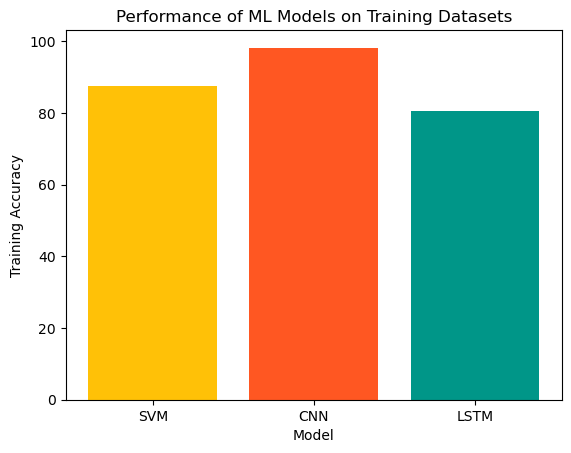

In [197]:
#Graph comparing the performance of different ML models
import matplotlib.pyplot as plt

models = ['SVM', 'CNN', 'LSTM']
train_accuracy = [87.59, 98.15, 80.56]

plt.bar(models[0], train_accuracy[0], color='#FFC107')
plt.bar(models[1], train_accuracy[1], color='#FF5722')
plt.bar(models[2], train_accuracy[2], color='#009688')

plt.xlabel('Model')
plt.ylabel('Training Accuracy')
plt.title('Performance of ML Models on Training Datasets')
plt.show()

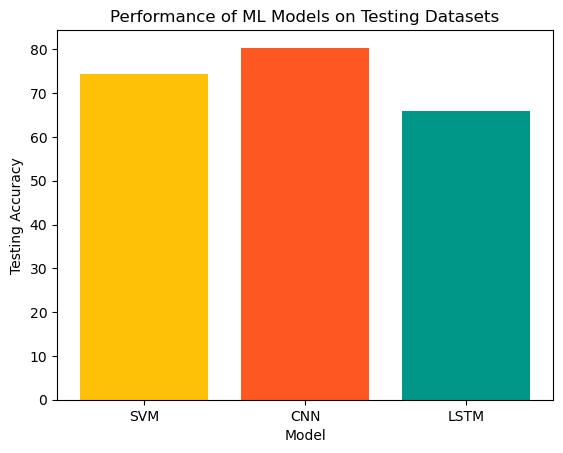

In [196]:
#Graph comparing the performance of different ML models
import matplotlib.pyplot as plt

models = ['SVM', 'CNN', 'LSTM']
test_accuracy = [74.44, 80.37, 65.93]

plt.bar(models[0], test_accuracy[0], color='#FFC107')
plt.bar(models[1], test_accuracy[1], color='#FF5722')
plt.bar(models[2], test_accuracy[2], color='#009688')

plt.xlabel('Model')
plt.ylabel('Testing Accuracy')
plt.title('Performance of ML Models on Testing Datasets')
plt.show()